In [2]:
spark

In [3]:
orders_silver_df = spark.read.json("/content/drive/MyDrive/retail_data_analysis/data/silver/orders_clean.json")

In [4]:
customers_silver_df = spark.read.json("/content/drive/MyDrive/retail_data_analysis/data/silver/customers_clean.json")

In [5]:
order_items_silver_df = spark.read.json("/content/drive/MyDrive/retail_data_analysis/data/silver/order_items_clean.json")

In [6]:
orders_silver_df.show()

+-----------------+----------+--------+---------------+
|order_customer_id|order_date|order_id|   order_status|
+-----------------+----------+--------+---------------+
|            11599|2013-07-25|       1|         CLOSED|
|              256|2013-07-26|       2|       COMPLETE|
|            12111|2013-07-27|       3|PENDING_PAYMENT|
|             8827|2013-07-29|       5|       COMPLETE|
|             9475|2013-07-31|       7|         CLOSED|
|            15023|2013-08-01|       8|       COMPLETE|
+-----------------+----------+--------+---------------+



In [42]:
customers_silver_df.show()

+-------------+--------------------+--------------+-----------+--------------+--------------+
|customer_city|      customer_email|customer_fname|customer_id|customer_lname|customer_state|
+-------------+--------------------+--------------+-----------+--------------+--------------+
|       Caguas|john.smith@exampl...|          John|      11599|         Smith|            PR|
|        Miami|alice.johnson@exa...|         Alice|        256|       Johnson|            FL|
|      Seattle|  unknown@domain.com|           Bob|      12111|         Brown|            WA|
|      Unknown|maria.garcia@exam...|         Maria|       8827|        Garcia|            TX|
|      Phoenix|carlos.martinez@e...|        Carlos|      11318|      Martinez|            AZ|
|       Boston|olivia.lopez@exam...|        Olivia|       9475|         Lopez|       Unknown|
|       Denver|noah.davis@exampl...|          Noah|      15023|         Davis|            CO|
|      Toronto|emma.williams@exa...|          Emma|       NU

In [11]:
orders_silver_df.createOrReplaceTempView('orders')
customers_silver_df.createOrReplaceTempView('customers')
order_items_silver_df.createOrReplaceTempView('order_items')

In [15]:
spark.sql("""
        select
          *
        from
          orders join customers on orders.order_customer_id = customers.customer_id
                join order_items on orders.order_id = order_items.order_id
""").show()

+-----------------+----------+--------+---------------+-------------+--------------------+--------------+-----------+--------------+--------------+--------+-------------+---------------------+------------------------+-------------------+-------------------+
|order_customer_id|order_date|order_id|   order_status|customer_city|      customer_email|customer_fname|customer_id|customer_lname|customer_state|order_id|order_item_id|order_item_product_id|order_item_product_price|order_item_quantity|order_item_subtotal|
+-----------------+----------+--------+---------------+-------------+--------------------+--------------+-----------+--------------+--------------+--------+-------------+---------------------+------------------------+-------------------+-------------------+
|            11599|2013-07-25|       1|         CLOSED|       Caguas|john.smith@exampl...|          John|      11599|         Smith|            PR|       1|            1|                  101|                   200.0|         

In [16]:
gold_df = (orders_silver_df
           .join(customers_silver_df, orders_silver_df.order_customer_id == customers_silver_df.customer_id)
           .join(order_items_silver_df, "order_id"))

In [17]:
gold_df.show()

+--------+-----------------+----------+---------------+-------------+--------------------+--------------+-----------+--------------+--------------+-------------+---------------------+------------------------+-------------------+-------------------+
|order_id|order_customer_id|order_date|   order_status|customer_city|      customer_email|customer_fname|customer_id|customer_lname|customer_state|order_item_id|order_item_product_id|order_item_product_price|order_item_quantity|order_item_subtotal|
+--------+-----------------+----------+---------------+-------------+--------------------+--------------+-----------+--------------+--------------+-------------+---------------------+------------------------+-------------------+-------------------+
|       1|            11599|2013-07-25|         CLOSED|       Caguas|john.smith@exampl...|          John|      11599|         Smith|            PR|            1|                  101|                   200.0|                  2|             400.00|
|   

1. Top 10 customers by total spend

Sum of order_item_subtotal per customer.

In [29]:
spark.sql("""

  select customer_id,customer_fname, customer_lname, sum(order_item_subtotal) as total_spent  from orders join customers on orders.order_customer_id = customers.customer_id
  join order_items on orders.order_id = order_items.order_id
  group by customer_id,customer_fname, customer_lname
  order by total_spent desc
  limit 3
""").show()

+-----------+--------------+--------------+-----------+
|customer_id|customer_fname|customer_lname|total_spent|
+-----------+--------------+--------------+-----------+
|       8827|         Maria|        Garcia|     1250.0|
|      15023|          Noah|         Davis|     1250.0|
|      12111|           Bob|         Brown|      900.0|
+-----------+--------------+--------------+-----------+



In [30]:

from pyspark.sql.functions import sum as _sum, desc
premium_customers = (
    gold_df.groupBy("customer_id", "customer_fname", "customer_lname")
           .agg(_sum("order_item_subtotal").alias("total_spent"))
           .orderBy(desc("total_spent")).limit(3)
)

In [31]:
premium_customers.show()

+-----------+--------------+--------------+-----------+
|customer_id|customer_fname|customer_lname|total_spent|
+-----------+--------------+--------------+-----------+
|       8827|         Maria|        Garcia|     1250.0|
|      15023|          Noah|         Davis|     1250.0|
|      12111|           Bob|         Brown|      900.0|
+-----------+--------------+--------------+-----------+



2. Revenue per state

Join customers → orders → order_items; group by state.

In [13]:
from pyspark.sql.functions import sum as _sum, desc


revenue_state = (
    gold_df.groupBy("customer_state")
           .agg(_sum("order_item_subtotal").alias("total_revenue"))
           .orderBy(desc("total_revenue"))
)

In [14]:
revenue_state.show()

+--------------+-------------+
|customer_state|total_revenue|
+--------------+-------------+
|            TX|       1250.0|
|            CO|       1250.0|
|            WA|        900.0|
|       Unknown|        800.0|
|            PR|        400.0|
|            FL|        150.0|
+--------------+-------------+



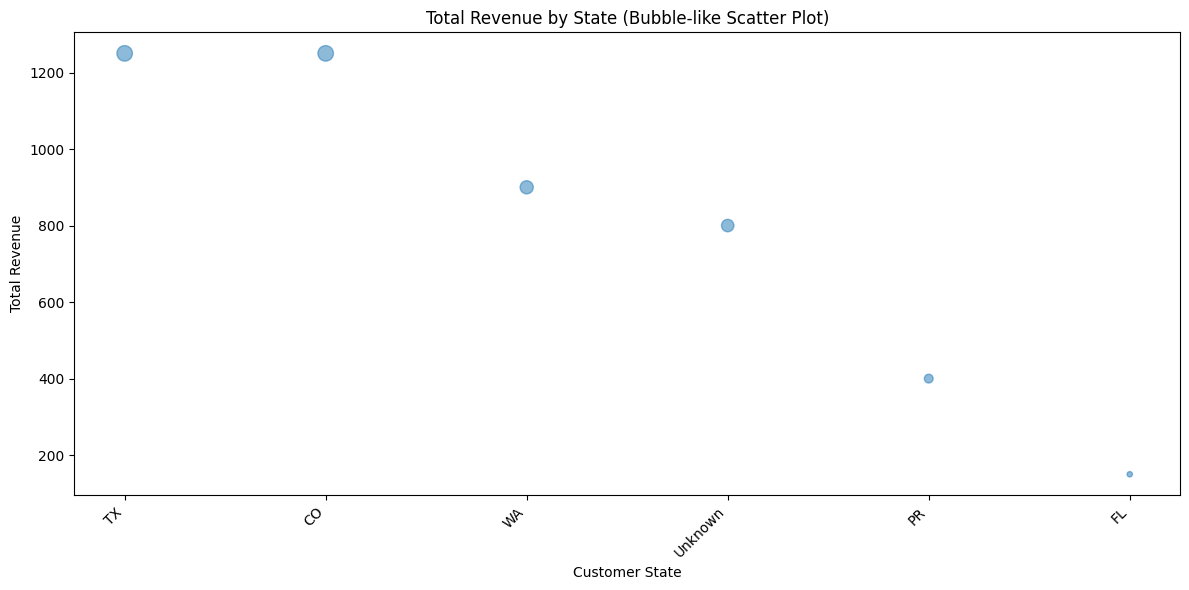

In [53]:
from pyspark.sql.functions import sum as _sum, desc
import matplotlib.pyplot as plt
import numpy as np

# Calculate revenue per state (re-running this cell as it was not executed in the current runtime)
revenue_state_df = (
    gold_df.groupBy("customer_state")
           .agg(_sum("order_item_subtotal").alias("total_revenue"))
           .orderBy(desc("total_revenue"))
)

# Convert to Pandas DataFrame for plotting
revenue_state_pd_df = revenue_state_df.toPandas()

# Create a scatter plot with bubble-like markers
plt.figure(figsize=(12, 6))
# Use a numerical representation for states on the x-axis for the scatter plot
x_positions = np.arange(len(revenue_state_pd_df["customer_state"]))
# Scale the size of the bubbles based on revenue
bubble_sizes = revenue_state_pd_df["total_revenue"] / 10 # Adjust scaling factor as needed
plt.scatter(x_positions, revenue_state_pd_df["total_revenue"], s=bubble_sizes, alpha=0.5)

# Set the x-axis ticks and labels to be the state names
plt.xticks(x_positions, revenue_state_pd_df["customer_state"], rotation=45, ha="right")

plt.xlabel("Customer State")
plt.ylabel("Total Revenue")
plt.title("Total Revenue by State (Bubble-like Scatter Plot)")
plt.tight_layout()
plt.show()

In [54]:
%pip install plotly

In [55]:
import plotly.express as px

# Assuming revenue_state_pd_df is already created and contains the data

fig = px.scatter(revenue_state_pd_df,
                 x="customer_state",
                 y="total_revenue",
                 size="total_revenue",
                 hover_name="customer_state",
                 hover_data={"customer_state": False, "total_revenue": ':.2f'},
                 title="Total Revenue by State (Interactive Bubble Plot)")
fig.show()

# 3. **Monthly** revenue trend

Extract month/year from order_date.

In [35]:
spark.sql("""
  select year(order_date) as year,
  month(order_date) as month,
  sum(order_item_subtotal) as monthly_revenue from orders join
  customers on orders.order_customer_id = customers.customer_id join
  order_items on orders.order_id = order_items.order_id
  group by year , month
  order by monthly_revenue desc
  """).show()

+----+-----+---------------+
|year|month|monthly_revenue|
+----+-----+---------------+
|2013|    7|         3500.0|
|2013|    8|         1250.0|
+----+-----+---------------+



In [15]:
from pyspark.sql.functions import year, month, sum as _sum
monthly_revenue = (
    gold_df.withColumn("year", year("order_date"))
           .withColumn("month", month("order_date"))
           .groupBy("year", "month")
           .agg(_sum("order_item_subtotal").alias("monthly_revenue"))
           .orderBy("year", "month")
)


In [16]:
monthly_revenue.show()

+----+-----+---------------+
|year|month|monthly_revenue|
+----+-----+---------------+
|2013|    7|         3500.0|
|2013|    8|         1250.0|
+----+-----+---------------+



# 4.**Average** order value (AOV)

Total revenue ÷ total number of orders.

In [39]:
spark.sql("""
  select sum(order_item_subtotal)/ count(orders.order_id) as avrage_of_value from orders join
  order_items on orders.order_id = order_items.order_id


""") . show()

+-----------------+
|  avrage_of_value|
+-----------------+
|791.6666666666666|
+-----------------+



In [17]:
from pyspark.sql.functions import sum as _sum, countDistinct, round

aov_df = (
    gold_df
    .agg(
        (_sum("order_item_subtotal") / countDistinct("order_id")).alias("avg_order_value")
    )
)



In [20]:
from pyspark.sql.functions import round , col

aov_df = aov_df.withColumn("avg_order_value", round(col("avg_order_value"), 2))
aov_df.show()

+---------------+
|avg_order_value|
+---------------+
|         791.67|
+---------------+



In [40]:
gold_df.show()

+--------+-----------------+----------+---------------+-------------+--------------------+--------------+-----------+--------------+--------------+-------------+---------------------+------------------------+-------------------+-------------------+
|order_id|order_customer_id|order_date|   order_status|customer_city|      customer_email|customer_fname|customer_id|customer_lname|customer_state|order_item_id|order_item_product_id|order_item_product_price|order_item_quantity|order_item_subtotal|
+--------+-----------------+----------+---------------+-------------+--------------------+--------------+-----------+--------------+--------------+-------------+---------------------+------------------------+-------------------+-------------------+
|       1|            11599|2013-07-25|         CLOSED|       Caguas|john.smith@exampl...|          John|      11599|         Smith|            PR|            1|                  101|                   200.0|                  2|             400.00|
|   

# 5.**Most** sold product IDs

Count order_item_quantity per product

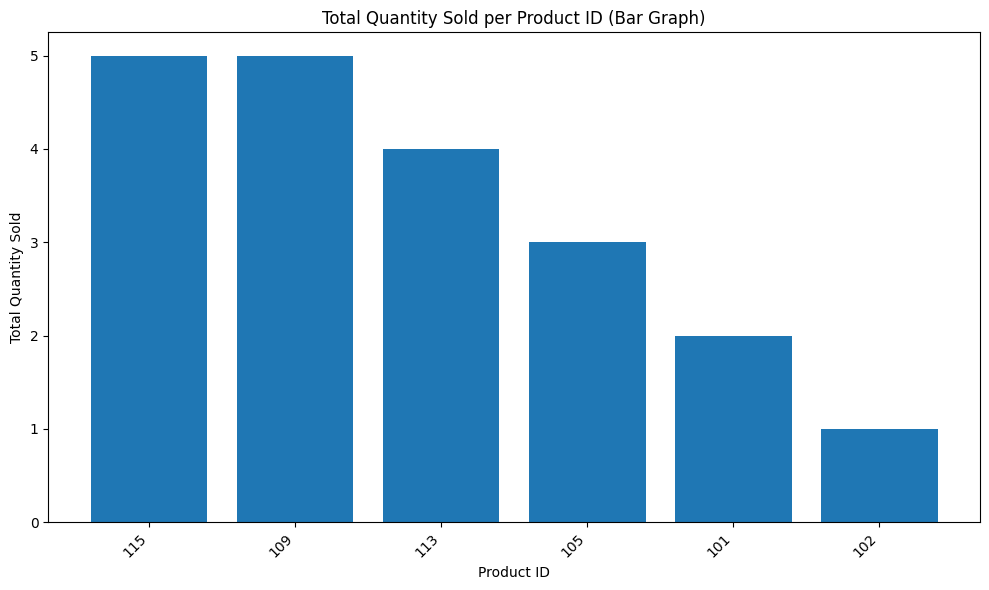

In [51]:
from pyspark.sql.functions import sum as _sum
import matplotlib.pyplot as plt

# Calculate total quantity sold per product
most_sold_products_df = (
    gold_df
    .groupBy("order_item_product_id")
    .agg(_sum("order_item_quantity").alias("total_quantity_sold"))
    .orderBy(col("total_quantity_sold").desc())
)

# Convert to Pandas DataFrame for plotting
most_sold_products_pd_df = most_sold_products_df.toPandas()

# Create bar graph
plt.figure(figsize=(10, 6))
plt.bar(most_sold_products_pd_df["order_item_product_id"], most_sold_products_pd_df["total_quantity_sold"])
plt.xlabel("Product ID")
plt.ylabel("Total Quantity Sold")
plt.title("Total Quantity Sold per Product ID (Bar Graph)")
plt.xticks(rotation=45, ha="right") # Rotate labels for better readability
plt.tight_layout() # Adjust layout to prevent labels overlapping
plt.show()

In [41]:
spark.sql("""
  select order_item_product_id, sum(order_item_quantity) as total_quantity_sold from orders join
  order_items on orders.order_id = order_items.order_id
  group by order_item_product_id

""").show()

+---------------------+-------------------+
|order_item_product_id|total_quantity_sold|
+---------------------+-------------------+
|                  101|                  2|
|                  113|                  4|
|                  102|                  1|
|                  115|                  5|
|                  105|                  3|
|                  109|                  5|
+---------------------+-------------------+



In [22]:
from pyspark.sql.functions import sum as _sum

most_sold_products_df = (
    gold_df
    .groupBy("order_item_product_id")
    .agg(_sum("order_item_quantity").alias("total_quantity_sold"))
    .orderBy(col("total_quantity_sold").desc())
)

most_sold_products_df.show()


+---------------------+-------------------+
|order_item_product_id|total_quantity_sold|
+---------------------+-------------------+
|                  115|                  5|
|                  109|                  5|
|                  113|                  4|
|                  105|                  3|
|                  101|                  2|
|                  102|                  1|
+---------------------+-------------------+



# 6. **Orders** missing customer info

Check data quality post-cleaning

In [45]:
spark.sql("""
  select * from customers where customer_id not in (select order_customer_id from orders)

""").show()

+-------------+--------------------+--------------+-----------+--------------+--------------+
|customer_city|      customer_email|customer_fname|customer_id|customer_lname|customer_state|
+-------------+--------------------+--------------+-----------+--------------+--------------+
|      Phoenix|carlos.martinez@e...|        Carlos|      11318|      Martinez|            AZ|
+-------------+--------------------+--------------+-----------+--------------+--------------+



In [46]:
from pyspark.sql.functions import col
orders_missing_customer_df = gold_df.filter(
    col("customer_id").isNull() |
    col("customer_city").isNull() |
    (col("customer_city") == "Unknown") |
    col("customer_email").isNull() |
    (col("customer_email") == "unknown@domain.com")
)

orders_missing_customer_df.show()


+--------+-----------------+----------+---------------+-------------+--------------------+--------------+-----------+--------------+--------------+-------------+---------------------+------------------------+-------------------+-------------------+
|order_id|order_customer_id|order_date|   order_status|customer_city|      customer_email|customer_fname|customer_id|customer_lname|customer_state|order_item_id|order_item_product_id|order_item_product_price|order_item_quantity|order_item_subtotal|
+--------+-----------------+----------+---------------+-------------+--------------------+--------------+-----------+--------------+--------------+-------------+---------------------+------------------------+-------------------+-------------------+
|       3|            12111|2013-07-27|PENDING_PAYMENT|      Seattle|  unknown@domain.com|           Bob|      12111|         Brown|            WA|            3|                  105|                     0.0|                  3|             900.00|
|   

In [48]:
premium_customers.write.mode("overwrite").parquet("/content/drive/MyDrive/retail_data_analysis/data/gold/premium_customers.parquet")

In [49]:
revenue_state.write.mode("overwrite").parquet("/content/drive/MyDrive/retail_data_analysis/data/gold/revenue_state.parquet")


NameError: name 'revenue_state' is not defined

In [26]:
monthly_revenue.write.mode("overwrite").parquet("/content/drive/MyDrive/retail_data_analysis/data/gold/monthly_revenue.parquet")


In [27]:
aov_df.write.mode("overwrite").parquet("/content/drive/MyDrive/retail_data_analysis/data/gold/aov_df.parquet")


In [28]:
most_sold_products_df.write.mode("overwrite").parquet("/content/drive/MyDrive/retail_data_analysis/data/gold/most_sold_products.parquet")

In [29]:
orders_missing_customer_df.write.mode("overwrite").parquet("/content/drive/MyDrive/retail_data_analysis/data/gold/orders_missing_customer.parquet")
